<a href="https://colab.research.google.com/github/74Mazen74/Face-Recognition/blob/selmy/Assignment_1_PR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import cv2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
from IPython.display import clear_output
# Modify the first path to be the path of the data in your drive
!unzip /content/drive/MyDrive/PatternRecognition/Assignment1Data/archive.zip -d /content/sample_data/archive
clear_output(wait=False)

## Read images

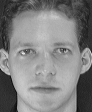

In [5]:
from google.colab.patches import cv2_imshow
import cv2
img = cv2.imread('/content/sample_data/archive/archive/s1/1.pgm', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [6]:
images=[]
labels=[]
for i in range(1,41):
  photos = os.listdir('/content/sample_data/archive/archive/s'+str(i))
  for photo in photos:
    img = cv2.imread('/content/sample_data/archive/archive/s'+str(i)+"/"+photo,0) # zero for gray scale
    img_col = np.array(img, dtype='float64').flatten()
    sub = int(i)
    images.append(img_col)
    labels.append(sub)

In [7]:
df=pd.DataFrame(data=images)
df['target']=labels
df.head()

,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,target
0,48.0,49.0,45.0,47.0,49.0,57.0,39.0,42.0,53.0,49.0,...,44.0,40.0,41.0,49.0,42.0,44.0,47.0,46.0,46.0,1
1,41.0,47.0,47.0,46.0,44.0,49.0,48.0,58.0,61.0,49.0,...,34.0,35.0,34.0,36.0,34.0,39.0,35.0,37.0,38.0,1
2,39.0,44.0,53.0,37.0,61.0,48.0,61.0,45.0,35.0,40.0,...,30.0,36.0,32.0,28.0,32.0,31.0,29.0,26.0,29.0,1
3,63.0,53.0,35.0,36.0,33.0,34.0,31.0,35.0,39.0,43.0,...,169.0,166.0,161.0,158.0,169.0,137.0,41.0,10.0,24.0,1
4,43.0,50.0,41.0,58.0,78.0,83.0,67.0,48.0,44.0,46.0,...,164.0,164.0,162.0,159.0,156.0,155.0,158.0,153.0,169.0,1


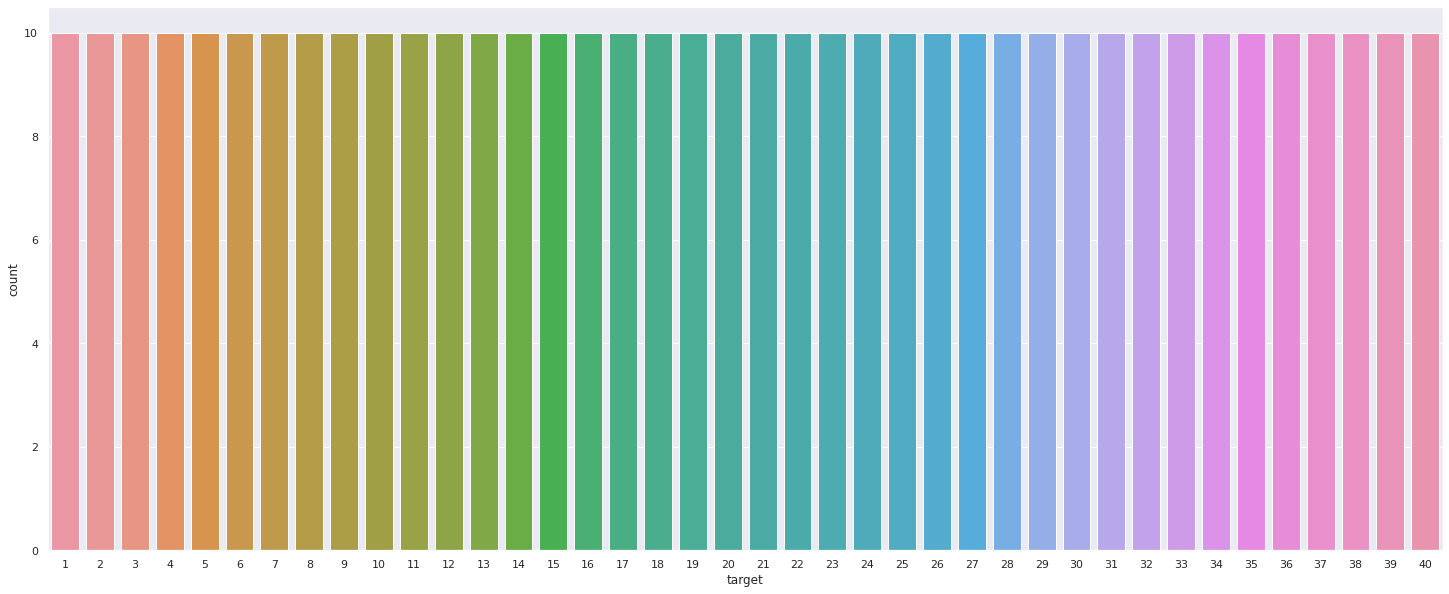

In [116]:
sns.countplot(x='target', data=df)
sns.set(rc={'figure.figsize':(25,10)})

##Train Test Split

In [8]:
df_test = df[df.index % 2 == 0]
df_train = df[df.index % 2 != 0]

## PCA

In [9]:
#Calculating mean
def calculate_mean(data):
    return np.mean(data)

#Centralize data
def centeralize(data):
    return data - calculate_mean(data)

#Covariance Matrix
def calculate_covariance_matrix(data):
    z = centeralize(data)
    return (np.matmul(np.transpose(z), z)) / len(data)

#Calculating Eigen values & Eigen vectors
def calculate_eigen_vectors(data):
    cov = calculate_covariance_matrix(data)
    eig_values, eig_vectors = np.linalg.eigh(cov)
    idx = eig_values.argsort()[::-1]   
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]
    return eig_values, eig_vectors

#Choosing dimensionality
def dimensionality(alpha, eig_values):
    sum = np.sum(eig_values)
    r = 0
    i = 0
    for value in eig_values: 
        r = r + eig_values[i]
        i = i + 1
        if (r / sum >= alpha):
            break
    return i

def reduce_matrix(r, matrix):
  U = np.transpose(matrix)
  U = U[:][0:r]
  U = np.transpose(U)
  return U

def PCA(alpha,X_train,X_test):
    eig_values, eig_vectors = calculate_eigen_vectors(X_train)
    r = dimensionality(alpha, eig_values)
    print("r = ", r)
    U = reduce_matrix(r, eig_vectors)
    projected_training = np.dot(X_train, U)
    projected_testing = np.dot(X_test, U)
    return projected_training, projected_testing


In [24]:
X_train=df_train.drop(columns='target')
X_test=df_test.drop(columns='target')
y_train=df_train['target']
y_test=df_test['target']

In [11]:
accuracy=[]

In [120]:
model = KNeighborsClassifier(n_neighbors=1)
alphas=[0.8,0.85,0.9,0.95]
for i in range(len(alphas)):
  projected_training, projected_testing = PCA(alphas[i],X_train,X_test)
  model.fit(projected_training, y_train)
  test_pred = model.predict(projected_testing)
  print(classification_report(y_test, test_pred))
  accuracy.append(accuracy_score(y_test, test_pred))

<ipython-input-118-ddf5c8517168>:12: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  return (np.matmul(np.transpose(z), z)) / len(data)


r =  35
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.80      0.80      0.80         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       0.83      1.00      0.91         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       0.83      1.00      0.91         5
          18       

<ipython-input-118-ddf5c8517168>:12: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  return (np.matmul(np.transpose(z), z)) / len(data)


r =  51
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       0.80      0.80      0.80         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       0.83      1.00      0.91         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       0.83      1.00      0.91         5
          17       1.00      1.00      1.00         5
          18       

<ipython-input-118-ddf5c8517168>:12: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  return (np.matmul(np.transpose(z), z)) / len(data)


r =  74
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       0.80      0.80      0.80         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       0.83      1.00      0.91         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       0.83      1.00      0.91         5
          17       1.00      1.00      1.00         5
          18       

<ipython-input-118-ddf5c8517168>:12: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  return (np.matmul(np.transpose(z), z)) / len(data)


KeyboardInterrupt: ignored

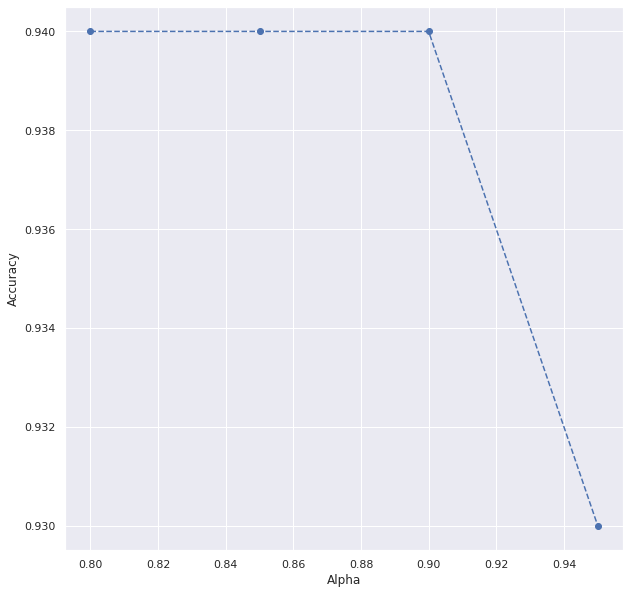

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(alphas, accuracy,'--bo', label='line with marker')
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()

##LDA

In [25]:
# Calculating mean vector for every class¶
from collections import defaultdict


def calculate_classes_mean(data, classes_count):
    original_dimensions = 10304
    mean_vector = dict()
    for label in range(1, classes_count + 1):
        # print(data[1])
        # label = str(label)
        # print("HH/HH",label)
        # print(data.loc[1])
        person_data = data.iloc[[label]]
        # print("Hohohoho")
        # print(person_data)
        # data[data[''] == label]
        mean = np.mean(person_data)
        # print("-----------")
        # print(mean)
        mean_vector[label] = mean
    # print(mean_vector)
    return mean_vector

# Calculating Sb and S matrices
def calculate_scatter_matrices(data, original_dimensions, classes_count):
    total_mean = np.mean(data)
    S = np.zeros((original_dimensions, original_dimensions))
    SB = np.zeros((original_dimensions, original_dimensions))
    print("BEfore")
    # print(data[1])
    mean_vector = calculate_classes_mean(data, classes_count)
    print("After")
    for label in range(1, classes_count + 1):
        # label = str(label)
        print("Calculating label " + str(label))
        person_data = data.iloc[[label]]
        mean_vector[label]
        Z = np.array(person_data - mean_vector[label])
        # calculating S matrix
        S += Z.T.dot(Z)
        nk = person_data.shape[0]
        # Reshaping mean_diff
        mean_diff = np.array(mean_vector[label] - total_mean).reshape(original_dimensions, 1)
        # calculating Sb matrix
        SB += nk * (mean_diff).dot(mean_diff.T)
    return S, SB

In [26]:
def LDA(n_components, data, original_dimensions, classes_count):
    # print("Hello")
    S, SB = calculate_scatter_matrices(data, original_dimensions, classes_count)
    A = np.linalg.inv(S).dot(SB)
    eig_values, eig_vectors = np.linalg.eigh(A)
    # sort eigenvalues descendingly
    idx = eig_values.argsort()[::-1]   
    eig_values = eig_values[idx]
    eig_vectors = eig_vectors[:,idx]

    # store first n eigenvectors
    U = eig_vectors[:, 0:n_components].T
    return U

In [27]:
train_data = pd.DataFrame(X_train,index=y_train)

In [28]:
zero_cols = [ col for col, is_zero in ((train_data == 0).sum() == train_data.shape[0]).items() if is_zero ]
zero_cols

[]

In [29]:
people=40
# print(train_data)
U = LDA(39, train_data, 10304, people)

projected_train_data = np.array(np.matmul(X_train, U.T))
projected_test_data = np.array(np.matmul(X_test, U.T))



BEfore
After
Calculating label 1
Calculating label 2
Calculating label 3
Calculating label 4
Calculating label 5
Calculating label 6
Calculating label 7
Calculating label 8
Calculating label 9
Calculating label 10
Calculating label 11
Calculating label 12
Calculating label 13
Calculating label 14
Calculating label 15
Calculating label 16
Calculating label 17
Calculating label 18
Calculating label 19
Calculating label 20
Calculating label 21
Calculating label 22
Calculating label 23
Calculating label 24
Calculating label 25
Calculating label 26
Calculating label 27
Calculating label 28
Calculating label 29
Calculating label 30
Calculating label 31
Calculating label 32
Calculating label 33
Calculating label 34
Calculating label 35
Calculating label 36
Calculating label 37
Calculating label 38
Calculating label 39
Calculating label 40


In [17]:
m# print(X_train.shape)
# print(X_test.shape)
# print(X_test.T.shape)
# tst=X_test.T
# print(tst[5])
test_data = pd.DataFrame(X_test,index=y_test)
test_data.shape
X_test=df_test.drop(columns='target')
X_train=df_train.drop(columns='target')
y_train.iloc[[0]]


1    1
Name: target, dtype: int64

In [18]:
X_test.iloc[1]

0        39.0
1        44.0
2        53.0
3        37.0
4        61.0
         ... 
10299    32.0
10300    31.0
10301    29.0
10302    26.0
10303    29.0
Name: 2, Length: 10304, dtype: float64

In [19]:
simple_classifier = KNeighborsClassifier(n_neighbors=1)
simple_classifier.fit(X_train, y_train)
test_samples = len(X_test)
acc = 0
y_predict = []
for i in range(test_samples):
    result = simple_classifier.predict(X_test.iloc[[i]])
    # print(result)
    # print(y_test)
    y_predict.append(result)
    if result == y_test.iloc[i]:
        acc += 1
# y_test.iloc[[1]]    
acc /= test_samples
print(f'Acc at K = {1}: {acc*100} %')

Acc at K = 1: 94.0 %


In [22]:
# y_test = np.nan_to_num(y_test)
# y_train = np.nan_to_num(y_train)
# projected_train_data = np.nan_to_num(projected_train_data)
# projected_test_data = np.nan_to_num(projected_test_data)



In [20]:
def classify(X_train, y_train, X_test, y_test, n_neighbors, confusion_matrix_needed=False):
    simple_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    simple_classifier.fit(X_train, y_train)
    test_samples = len(X_test)
    acc = 0
    y_predict = []
    for i in range(test_samples):
        result = simple_classifier.predict(X_test.iloc[[i]])
        y_predict.append(result)
        if result == y_test.iloc[i]:
            acc += 1
        
    acc /= test_samples
    print(f'Acc at K = {n_neighbors}: {acc*100} %')

In [23]:
k_values = [1, 3, 5, 7]
acc = []
for k in k_values:
    acc.append(classify(projected_train_data, y_train, projected_test_data, y_test, k))
plt.plot(k_values, acc)
plt.xlabel('Number of neighbors')
plt.ylabel('Acc')
plt.title('K tunning graph')
plt.show()

AttributeError: ignored

## Classifier tuning PCA

In [ ]:
Ks=[3,5,7]

In [ ]:
for j in range(len(Ks)):
  kAccuracy=[]
  model = KNeighborsClassifier(n_neighbors=Ks[j])
  alphas=[0.8,0.85,0.9,0.95]
  for i in range(len(alphas)):
    projected_training, projected_testing = PCA(alphas[i],X_train,X_test)
    model.fit(projected_training, y_train)
    test_pred = model.predict(projected_testing)
    print(classification_report(y_test, test_pred))
    kAccuracy.append(accuracy_score(y_test, test_pred))
  plt.figure(figsize=(10,10))
  plt.plot(alphas, kAccuracy,'--bo', label='line with marker')
  plt.title("Accuracy using K ="+str(j))
  plt.xlabel("Alpha")
  plt.ylabel("Accuracy")
  plt.show()

<ipython-input-9-ddf5c8517168>:12: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  return (np.matmul(np.transpose(z), z)) / len(data)
